# NN

In [1]:
import pandas as pd
import keras
import utils
from keras.models import model_from_yaml
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
import numpy as np
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)

%matplotlib inline

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [166]:
# load data
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
data = {
    'tra': pd.read_csv('{}/air_visit_data.csv'.format(data_dir)),
    # 'tes': pd.read_csv('{}/sample_submission.csv'.format(data_dir)),
    'as': pd.read_csv('{}/air_store_info.csv'.format(data_dir)),
    'hs': pd.read_csv('{}/hpg_store_info.csv'.format(data_dir)),
    'ar': pd.read_csv('{}/air_reserve.csv'.format(data_dir)),
    'hr': pd.read_csv('{}/hpg_reserve.csv'.format(data_dir)),
    'id': pd.read_csv('{}/store_id_relation.csv'.format(data_dir)),
    'hol': pd.read_csv('{}/date_info.csv'.format(data_dir))
}
# Prepare store info
data['as'] = data['as'].rename({'latitude': 'air_latitude', 'longitude': 'air_longitude'}, axis='columns')
data['hs'] = data['hs'].rename({'latitude': 'hpg_latitude', 'longitude': 'hpg_longitude'}, axis='columns')
stores = pd.merge(data['as'],  data['id'], how='left' )
stores = pd.merge(stores,  data['hs'], how='left')
# only use air_store_id
stores = stores.drop(columns=['hpg_store_id'])

# Prepare static of stores
key = 'air_store_id'
agg = data['tra'].groupby(key).agg([np.min, np.max, np.mean, np.std]).rename(
  columns={
    'amin': 'min_{}'.format('visits'),
    'amax': 'max_{}'.format('visits'),
    'mean': 'mean_{}'.format('visits'),
    'std': 'std_{}'.format('visits')
})
agg.reset_index(inplace=True)
agg.columns = agg.columns.droplevel()
agg = agg.reset_index()
agg.rename(
    {
        '': key,
}, axis='columns', inplace=True)

#merge store statics into store info
stores = pd.merge(stores, agg)

In [4]:
stores.to_csv('./insight/store_stas.csv')

In [66]:
with open('result/model_bn.yml') as file_obj:
    model_yml = file_obj.read()

In [67]:
model = model_from_yaml(model_yml)

In [68]:
model.load_weights('result/model_bn_yy.h5')

In [5]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)
input_map = feas['x_map']
y = feas['y']
contin_cols = feas['contin_cols']
cat_map_fit = feas['cat_map_fit']
ts_date = feas['times']
s_i = ts_date[ts_date == '2016-04-23'].index[0]
e_i = ts_date[ts_date == '2016-06-01'].index[0]
# valid & trn splitting
map_train, map_valid, y_train_orig, y_valid_orig = utils.ts_data_split(input_map, y, s_i, e_i)
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")
/usr/local/lib64/python3.6/s

In [31]:
pred_valid = model.predict(map_valid)
# pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y/2)*2

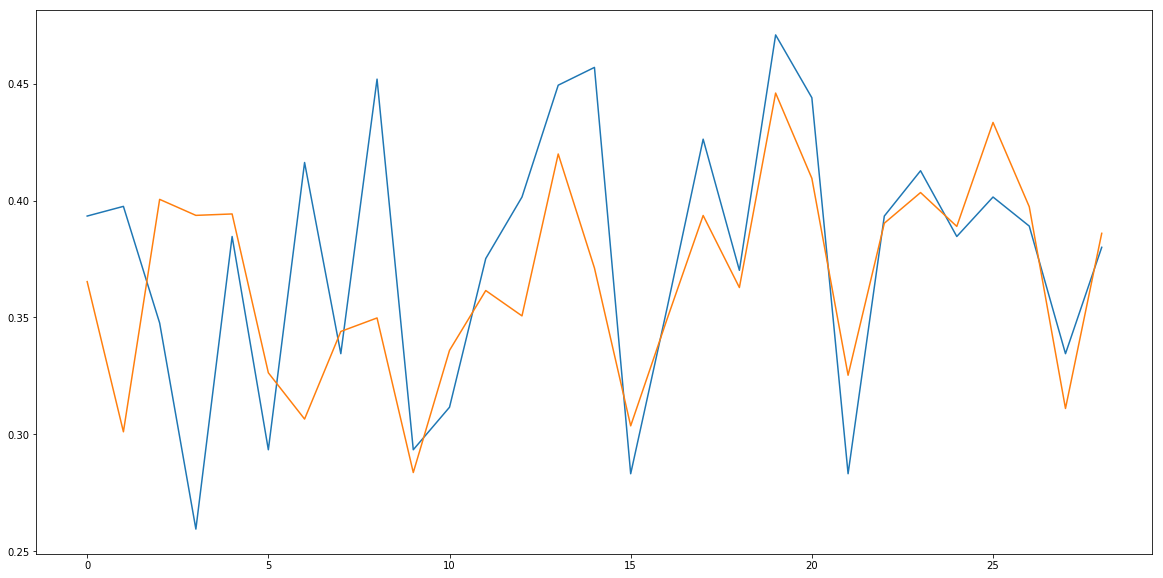

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid.values)
plt.plot(pred_valid.flatten())

In [33]:
pred_trn = model.predict(map_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)

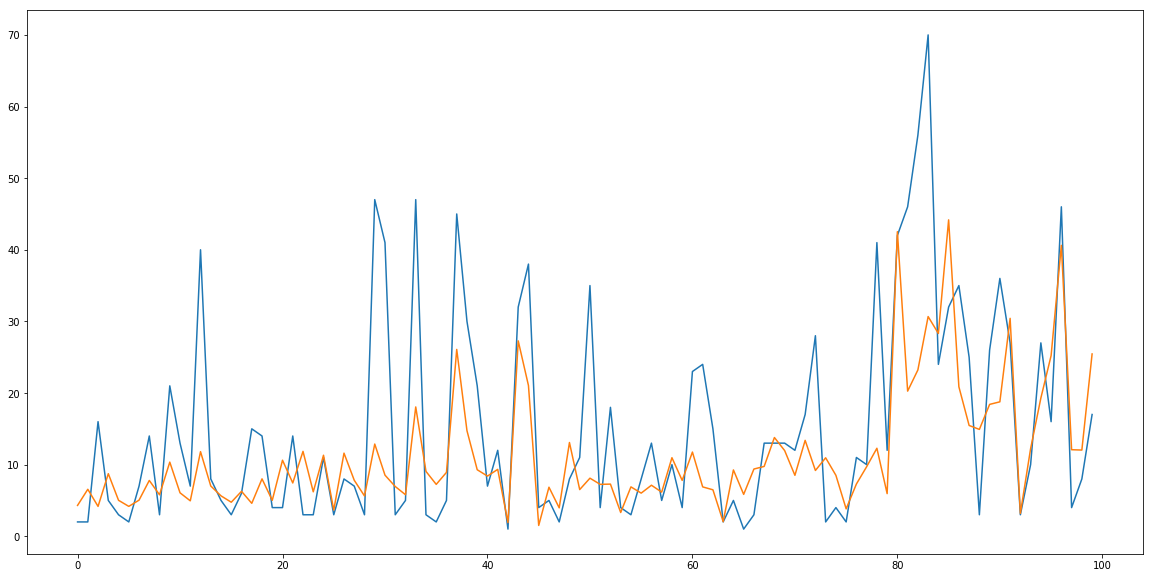

In [34]:
# edge s_p = 13100
s_p = 15200
win_len = 100

plt.figure(figsize=(20, 10))
plt.plot(y_train_orig[s_p:s_p+win_len])
plt.plot(pred_trn_orig[s_p:s_p+win_len].flatten())

In [39]:
map_train[11]

array([[-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       ..., 
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045]])

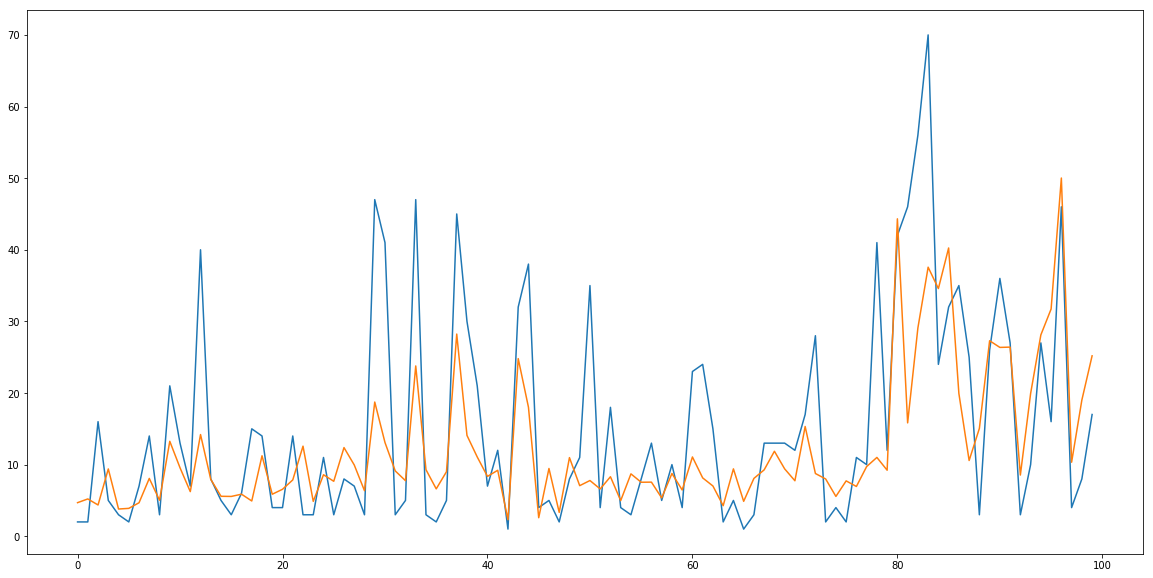

In [51]:

# edge s_p = 13100
s_p = 15200
win_len = 100

plt.figure(figsize=(20, 10))
plt.plot(y_train_orig[s_p:s_p+win_len])
plt.plot(pred_trn_orig[s_p:s_p+win_len].flatten())

(array([  2.51098000e+05,   9.31000000e+02,   3.30000000e+01,
          9.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   88.6,  176.2,  263.8,  351.4,  439. ,  526.6,  614.2,
         701.8,  789.4,  877. ]),
 <a list of 10 Patch objects>)

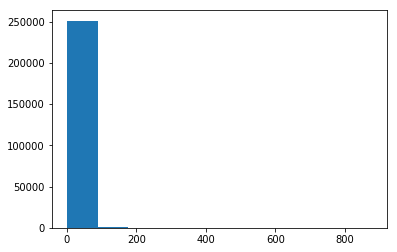

In [17]:
plt.hist(y_train_orig)

(array([  4.81100000e+03,   1.36420000e+04,   3.29410000e+04,
          6.41440000e+04,   7.52910000e+04,   5.37180000e+04,
          7.26700000e+03,   2.38000000e+02,   2.20000000e+01,
          5.00000000e+00]),
 array([ 0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,  0.48,  0.56,  0.64,
         0.72,  0.8 ]),
 <a list of 10 Patch objects>)

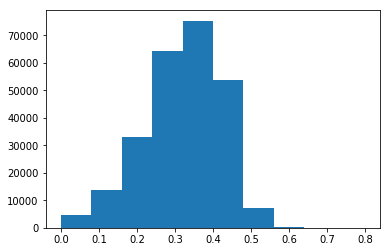

In [18]:
plt.hist(y_train)

(array([  1.73200000e+03,   1.83500000e+03,   4.14500000e+03,
          1.25570000e+04,   1.43593000e+05,   6.70450000e+04,
          1.77280000e+04,   3.21000000e+03,   2.08000000e+02,
          2.60000000e+01]),
 array([  7.62157072e-07,   6.63138991e-02,   1.32627036e-01,
          1.98940173e-01,   2.65253310e-01,   3.31566447e-01,
          3.97879584e-01,   4.64192720e-01,   5.30505857e-01,
          5.96818994e-01,   6.63132131e-01]),
 <a list of 10 Patch objects>)

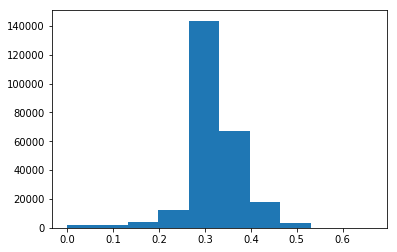

In [19]:
plt.hist(pred_trn)

In [78]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)

In [79]:
trn_like_test.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,100
1,air_00a91d42b08b08d9,2017-04-24,100
2,air_00a91d42b08b08d9,2017-04-25,100
3,air_00a91d42b08b08d9,2017-04-26,100
4,air_00a91d42b08b08d9,2017-04-27,100


array([ 70.,  16.,  30., ...,  21.,  65.,  74.])

# Submission

In [84]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = np.round(np.random.rand(len(trn_like_test)) * 100))
feas = utils.data2fea(trn_like_test, data_dir)
input_map = feas['sk_fea']
y = feas['y']

In [70]:
pred_test = model.predict(input_map)
pred_test_orig = utils.log_max_inv(pred_test, max_log_y)
# pred_test_orig[pred_test_orig>1000] = pred_test_orig[pred_test_orig<1000].mean()

ValueError: Error when checking model : the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 13 array(s), but instead got the following list of 12 arrays: [array([[ 6],
       [ 6],
       [ 6],
       ..., 
       [12],
       [12],
       [12]]), array([[32],
       [32],
       [32],
       ..., 
       [64],
       [64],
       [64]]), array([[15],
...

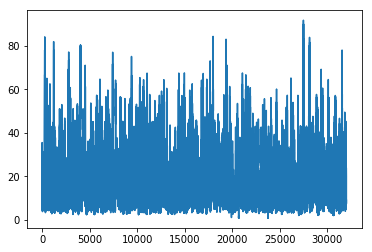

In [22]:
plt.plot(pred_test_orig)

In [23]:
test.visitors = pred_test_orig

In [24]:
test.to_csv('result/submission.csv', index=False)

# Explore results

In [52]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)
input_map = feas['x_map']
y = feas['y']

/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")


In [53]:
pred_trn = model.predict(input_map)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn = trn.assign(pred=pred_trn_orig)
trn = trn.assign(diff_val=np.abs(trn.pred - trn.visitors))
trn = trn.assign(diff_ratio=np.divide(trn.diff_val, trn.visitors))

In [82]:
DataFrameSummary(trn).summary()

,air_store_id,visit_date,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
count,NaN,NaN,252108,252108,252108,252108,252108,252108,252108,252108,252108
mean,NaN,NaN,20.9738,25.001,3.01968,2016.31,6.2082,19.4187,5.84301,5.84301,0.424395
std,NaN,NaN,16.757,16.0084,1.92399,0.461542,3.68026,13.8287,7.65068,7.65068,0.769973
min,NaN,NaN,1,1,0,2016,1,1,0,0,0
25%,NaN,NaN,9,10,1,2016,3,9.00508,1.69926,1.69926,0.118536
50%,NaN,NaN,17,26,3,2016,7,16.0588,3.86901,3.86901,0.252894
75%,NaN,NaN,29,39,5,2017,10,26.3859,7.63295,7.63295,0.449575
max,NaN,NaN,877,53,6,2017,12,206.999,859.973,859.973,32.3515
counts,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108
uniques,829,478,204,53,7,2,12,248368,249496,249496,251244


In [83]:
agg = trn.groupby('air_store_id').mean()

In [85]:
agg = agg.sort_values('diff_ratio')

In [88]:

DataFrameSummary(agg).summary()

,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
count,829,829,829,829,829,829,829,829,829
mean,21.2039,25.43,3.02443,2016.33,6.30872,19.6738,5.85496,5.85496,0.423868
std,11.775,3.32288,0.302565,0.120549,0.765667,11.6707,2.78625,2.78625,0.156497
min,1.1875,10.3667,2.03191,2016,2.83333,1.00132,0.188525,0.188525,0.0723492
25%,11.812,22.4159,2.91039,2016.24,5.60403,10.6193,3.90871,3.90871,0.311818
50%,19.1834,27.4475,3.02114,2016.37,6.77083,17.315,5.4273,5.4273,0.411022
75%,28.6452,27.7973,3.16239,2016.38,6.85659,26.9636,7.2956,7.2956,0.516158
max,115.471,36.1753,4.775,2017,8.78351,112.424,26.8287,26.8287,1.59998
counts,829,829,829,829,829,829,829,829,829
uniques,828,803,760,634,777,829,829,829,829


In [129]:
agg[ (agg.diff_ratio < 0.8) & (agg.diff_ratio > 0.6)].head()

,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
air_store_id,,,,,,,,,
air_bcce1ea4350b7b72,16.598592,27.665493,3.042254,2016.369718,6.841549,13.892851,6.700159,6.700159,0.601095
air_0164b9927d20bcc3,9.248322,25.335570,2.557047,2016.557047,6.268456,7.322750,4.034711,4.034711,0.601766
air_aed3a8b49abe4a48,9.080000,27.854545,3.061818,2016.360000,6.880000,7.566768,3.612044,3.612044,0.602255
air_ee3ba9af184c6c82,13.348684,31.750000,2.940789,2016.250000,7.776316,10.843468,5.682018,5.682018,0.602320
air_457efe8c3a30ea17,6.909326,22.238342,2.748705,2016.230570,5.577720,5.766316,3.036346,3.036346,0.602718


/usr/local/lib64/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


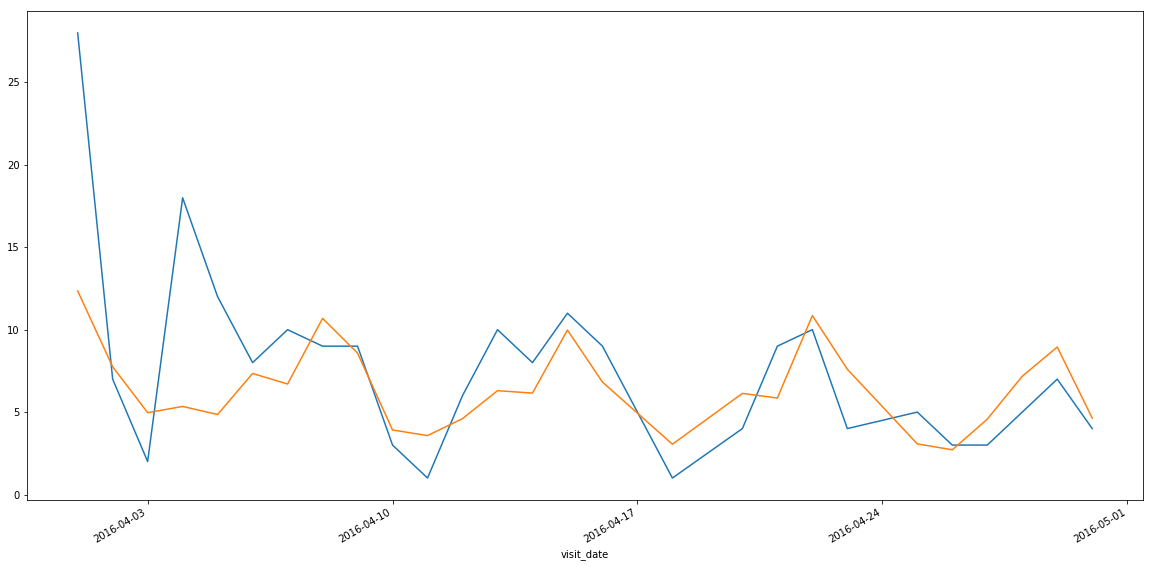

In [140]:
plt.figure(figsize=(20, 10))
a_store = trn[trn.air_store_id == "air_457efe8c3a30ea17"]
a_store.visit_date = pd.to_datetime(a_store.visit_date)
a_store = a_store.set_index('visit_date')
a_store['2016-04'].visitors.plot()
a_store['2016-04'].pred.plot()

# Xgboost

In [117]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import xgboost
import xgboost as xgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score

def split(df):
    trn_len = int(np.floor(len(df) * 0.9))
    valid_len = len(df) - trn_len
    df['type'] = 0  #0 for train 1 for valid
    indexs = df.index
    df = df.reset_index()
    df.loc[trn_len:, 'type'] =  1
    return df

In [2]:
prop = pd.read_pickle('./prop.pkl')

In [61]:
# drop_vars = [
# #     'air_store_id',
#     'mean_visits',
# #     'air_loc',
#     'visit_date_dayofweek',
# #     'area_name',
# #     'genre_name',
#     'visit_date_week',
#     'visit_date_month',
# #     'hpb_area_name',
    
# #     'hpb_loc',
#     'visit_date_year',
#     'holiday_flg'

# # TBD    
#     'max_visits',
#     'std_visits',
#     'min_visits',
#     'hpb_genre_name',     

#     'be_holiday_flg',
#     'af_holiday_flg',
#     'dur_time_holiday_flg',
#     'dur_holiday_flg',
#     'dur_prog_holiday_flg',
    
#     'rolling_60d_max',
#     'rolling_60d_min', 
#     'rolling_60d_median', 
#     'rolling_60d_std',
    
# #     'stores_in_area_name',
# #     'max_visits_in_area_name',
# #     'mean_visits_in_area_name',
# #     'std_visits_in_area_name',  
# #     'min_visits_in_area_name',
    
# #     'stores_in_air_loc',
# #     'mean_visits_in_air_loc',
# #     'std_visits_in_air_loc',
# #     'max_visits_in_air_loc',
# #     'min_visits_in_air_loc',

# # 'visit_date_ts',
    
#     'stores_in_hpb_area_name',
#     'std_visits_in_hpb_area_name',
#     'max_visits_in_hpb_area_name',
#     'min_visits_in_hpb_area_name',
#     'mean_visits_in_hpb_area_name',
    
#     'stores_in_hpb_loc',
#     'std_visits_in_hpb_loc',
#     'max_visits_in_hpb_loc',
#     'min_visits_in_hpb_loc',
#     'mean_visits_in_hpb_loc',
    
#     #visit date , date of month, frequency
     
# ]


In [176]:
data_raw = pd.read_csv('./data/air_visit_data.csv')
test = pd.read_csv('./data/sample_submission.csv')
data_with_prop = pd.read_csv('./data/air_visit_data_with_prop.csv')

In [177]:
data_with_prop.head()

,Unnamed: 0,air_store_id,visit_date,visitors,yhat,yhat_upper,yhat_lower
0,0,air_ba937bf13d40fb24,2016-01-13,25,20.826006,36.176016,11.993050
1,1,air_ba937bf13d40fb24,2016-01-14,32,17.580470,31.304972,10.314391
2,2,air_ba937bf13d40fb24,2016-01-15,29,30.992940,53.052232,17.798123
3,3,air_ba937bf13d40fb24,2016-01-16,22,24.052839,41.393775,13.277098
4,4,air_ba937bf13d40fb24,2016-01-18,6,10.986390,19.317860,6.218022


In [178]:
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data = data_raw[data_raw.air_store_id.isin(test_stores)]
tag_data = data.groupby('air_store_id').apply(split)
t = tag_data.set_index('index')
t['visit_date'] = pd.to_datetime(t.visit_date)
train_set = t[t.type == 0].drop(columns=['type'])
valid_set = t[t.type == 1].drop(columns=['type'])
len(train_set), len(train_set.air_store_id.unique()), len(valid_set), len(valid_set.air_store_id.unique())

(225049, 821, 25419, 821)

In [257]:
reload(utils)

<module 'utils' from '/Users/yangyang/workspace/ml_utils/proj/RRVF/utils.py'>

In [258]:
train_feas = utils.data2fea(train_set, './data', drop_vars=drop_vars)
valid_feas = utils.data2fea(valid_set, './data', drop_vars=drop_vars)

In [259]:
def getDataForModel(feas, feas_other):
    X = feas['sk_fea']
    y_origin = feas['y']
    tidy_data = feas['tidy_data']
    all_vars = feas['all_vars']
    display(len(all_vars))
#     y, y2, max_log_y = utils.uniform_y(y_origin, y_origin)
    y, y2, max_log_y = utils.uniform_y(y_origin, feas_other['y'])
    xdata = xgboost.DMatrix(X, label=y, feature_names=all_vars)
    return y, y_origin,max_log_y, xdata

In [260]:
train_y, train_y_origin, max_log_y, train_x = getDataForModel(train_feas, valid_feas)
valid_y, valid_y_origin, max_log_y_v, valid_x = getDataForModel(valid_feas, train_feas)
# max_log_y, max_log_y_v

13

13

In [255]:
drop_vars = df.feature[9:].values

In [268]:
cur_result = {}
# https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_parms = {
    'learning_rate': 0.1, # eta 
#     'booster': 'dart',
    'subsample': 0.8, 
    'colsample_bylevel': 0.8, 
    'silent': False, 
    'objective': 'reg:logistic',
    'seed': random.randint(0,1e9),
    "nthread": 4,
    'max_bin': 256,
    'tree_method': 'hist',
    'max_depth': 6 #  4,6,8,10,15,
    
}
model = xgboost.train(xgb_parms, 
                      train_x, 
                      num_boost_round=40, 
                      evals=[(valid_x, 'valid'), (train_x, 'train')], # which data to evaluate
                      feval=rmsle_wo_log, # function to evaluate results
                      evals_result=cur_result,# result will be saved here
                      xgb_model=None,  # load previous model
                      verbose_eval=4)
# model.eval(xdata_val)
pred_valid = model.predict(valid_x)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y_v)
valid_loss = rmsle(pred_valid_orig, valid_y_origin)
pred_trn = model.predict(train_x)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, train_y_origin)
print('train loss: {}, valid loss: {}'.format(trn_loss, valid_loss))
# evals_result[try_name] = cur_result

[0]	valid-rmse:0.176323	train-rmse:0.176746	valid-rmsle:1.49382	train-rmsle:1.4974
[4]	valid-rmse:0.123345	train-rmse:0.124094	valid-rmsle:1.04499	train-rmsle:1.05133
[8]	valid-rmse:0.091588	train-rmse:0.092471	valid-rmsle:0.775935	train-rmsle:0.78342
[12]	valid-rmse:0.07385	train-rmse:0.07472	valid-rmsle:0.62566	train-rmsle:0.633036
[16]	valid-rmse:0.064793	train-rmse:0.065548	valid-rmsle:0.548931	train-rmsle:0.555323
[20]	valid-rmse:0.060524	train-rmse:0.061119	valid-rmsle:0.512762	train-rmsle:0.517804
[24]	valid-rmse:0.058638	train-rmse:0.059085	valid-rmsle:0.496783	train-rmsle:0.500572
[28]	valid-rmse:0.057837	train-rmse:0.058165	valid-rmsle:0.490002	train-rmsle:0.492781
[32]	valid-rmse:0.057506	train-rmse:0.057745	valid-rmsle:0.487198	train-rmsle:0.489219
[36]	valid-rmse:0.057391	train-rmse:0.05755	valid-rmsle:0.486218	train-rmsle:0.487564
[39]	valid-rmse:0.057354	train-rmse:0.05747	valid-rmsle:0.485906	train-rmsle:0.486892
train loss: 0.486891606245699, valid loss: 0.485905584700

In [96]:
valid_data = pd.DataFrame()
valid_data['air_store_id'] = valid_feas['store_id']
valid_data['y'] = valid_y_origin
valid_data['yhat'] = pred_valid_orig

In [97]:
t_data = pd.DataFrame()
t_data['air_store_id'] = train_feas['store_id']
t_data['y'] = train_y_origin
t_data['yhat'] = pred_trn_orig

In [98]:
def getStoreLoss(df):
    return rmsle(df.y, df.yhat)

In [99]:
valid_loss = valid_data.groupby('air_store_id').apply(getStoreLoss)
valid_loss.head()

air_store_id
air_00a91d42b08b08d9    0.388636
air_0164b9927d20bcc3    0.827101
air_0241aa3964b7f861    0.453270
air_0328696196e46f18    0.602332
air_034a3d5b40d5b1b1    0.491080
dtype: float64

In [100]:
t_loss = t_data.groupby('air_store_id').apply(getStoreLoss)

In [101]:
vl = valid_loss.to_frame()
vl = vl.rename({
     0: 'valid_loss'
}, axis='columns')
vl = vl.reset_index()
tl = t_loss.to_frame()
tl = tl.rename({
     0: 'train_loss'
}, axis='columns')
tl = tl.reset_index()

In [102]:
loss = pd.merge(vl, tl, how='left', left_on='air_store_id', right_on='air_store_id')
len(loss)

821

In [104]:
# loss.to_csv('./data/xbg_prob_loss.csv')

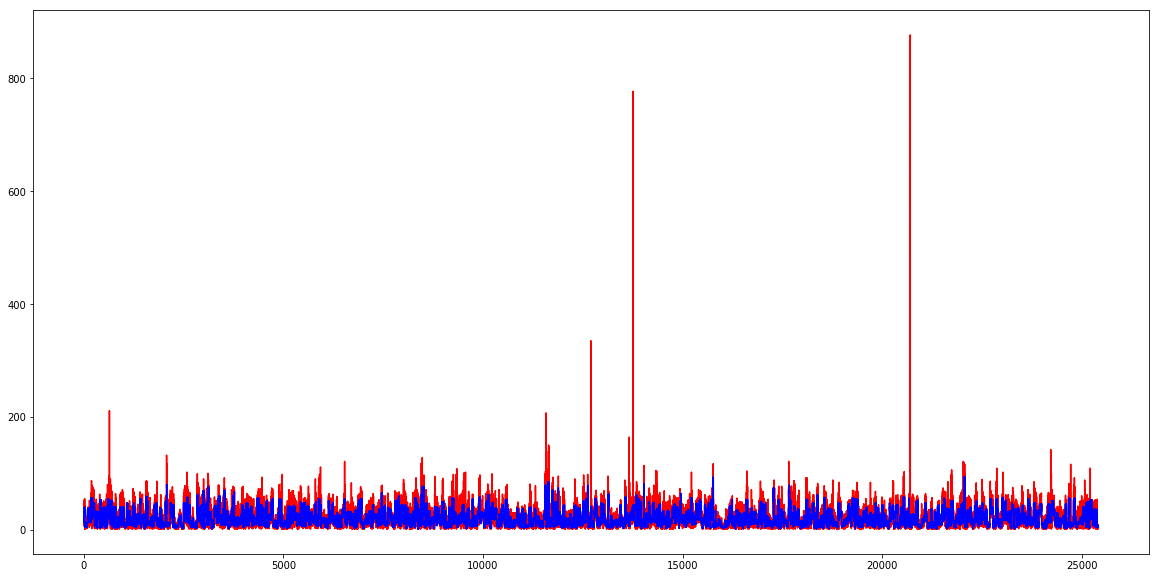

In [263]:
plt.figure(figsize=(20, 10))
plt.plot(valid_y_origin, 'r')
plt.plot(pred_valid_orig, 'b')

Text(0.5,0,'relative importance')

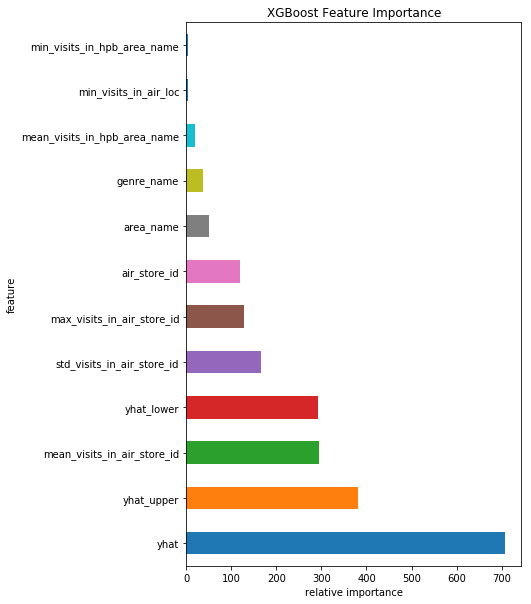

In [264]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
# df['fscore'] = df['fscore'] / df['fscore'].sum()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

# data slice
3

4 0.7012610665198485, valid loss: 0.7356819327974975

5 0.7011597208347141, valid loss: 0.7576457536626308

6 0.7142544767975981, valid loss: 0.7377355280995211

In [ ]:
# cv_result = xgb.cv(xgb_parms, xdata, num_boost_round=40, nfold=5,
#        metrics={'error'}, seed=0, feval=rmsle_wo_log,
#        callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
# cv_result

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

score = make_scorer(rmsle_wo_log_sk, greater_is_better=False)
param_grid = {
    'min_child_weight':[2],
    'learning_rate':[0.1],
    'max_depth': [3,4],
    'subsample': [0.8], 
    'colsample_bylevel': [0.6], 
    'n_estimators': [32]
}
fit_params = {
    "objective": 'reg:linear',
    "n_jobs": 4,
    "seed":  random.randint(0,1e9),
    "max_delta_step": 0,
    "olsample_bytree": 1,
    "colsample_bylevel": 1,
    "gamma": 0,
    "eg_alpha": 0, 
    "reg_lambda": 1, 
    "scale_pos_weight": 1, 
    "base_score": 0.5, 
    "random_state": 0,
    "booster": 'gbtree',
    "silent": False
}
xgb_gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**fit_params),
                          scoring=score,
                           return_train_score=True,
                          param_grid=param_grid)

In [29]:
res = xgb_gsearch.fit(X=X_train, 
         y=y_train)

0.7829076346293317
0.7913362672260535
0.7916175434686278
0.7871408638049332
0.798612491777245
0.7817214712562407
0.7736135640623134
0.7781766461745124
0.781995999376762
0.775680358354324
0.790805350268948
0.7697910959246055


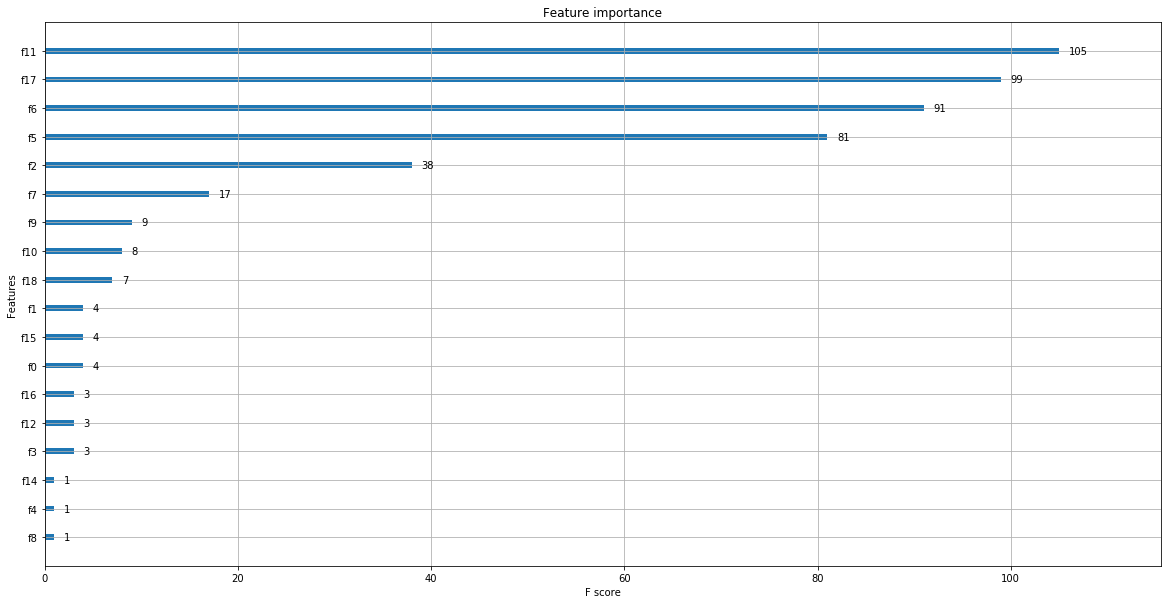

In [41]:
xgb.plot_importance(model)

In [34]:
model = res.best_estimator_

In [53]:
# joblib.dump(clf, "train_model.m")
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, eg_alpha=0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=2, missing=None,
       n_estimators=32, n_jobs=4, nthread=None, objective='reg:linear',
       olsample_bytree=1, random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=329200696, silent=False, subsample=0.8)

In [51]:
# model.eval(xdata_val)
pred_trn = model.predict(X_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn, y_train_orig)
pred_valid = model.predict(X_valid)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig)
print('data set: {}/{} train loss: {}, valid loss: {}'.format(data_i+1, len(dat), trn_loss, valid_loss))

data set: 1/1 train loss: 2.6341068693469385, valid loss: 0.8089054777016216


In [20]:
# model.save_model('result/xgboost.h5')
# bst.save_model('0001.model')
# # dump model
# bst.dump_model('dump.raw.txt')
# # dump model with feature map
# bst.dump_model('dump.raw.txt', 'featmap.txt')

# # load
# bst = xgb.Booster({'nthread': 4})  # init model
# bst.load_model('model.bin')  # load data

In [47]:

pred_trn = model.predict(xdata)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig)
evals_result[try_name] = cur_result

array([ 15.78474236,  21.56865311,  16.29379845, ...,  13.20959282,
        14.84749889,  18.34436035], dtype=float32)

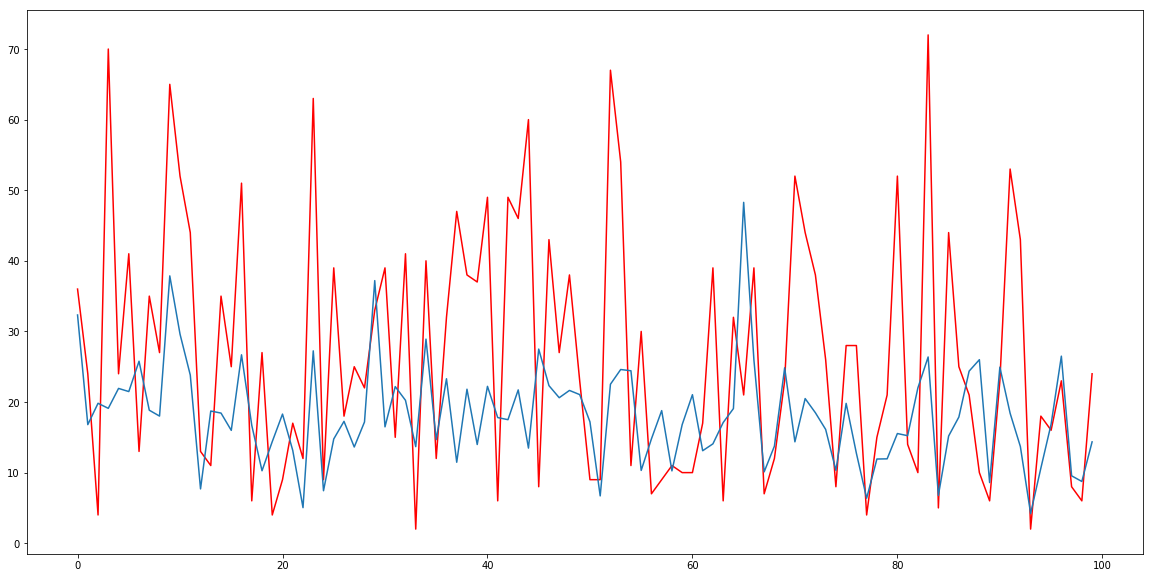

In [119]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid_orig.values[1000:1100], 'r')
plt.plot(pred_valid_orig.flatten()[1000:1100])

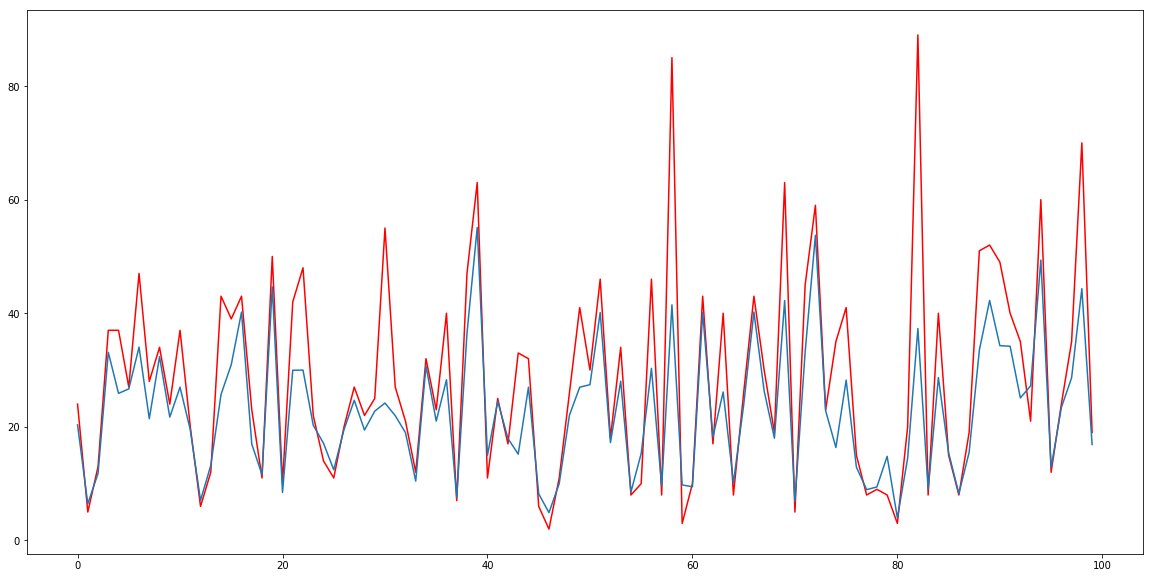

In [118]:
pred_trn = model.predict(xdata)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
plt.figure(figsize=(20, 10))
plt.plot(y_train_orig.values[1000:1100], 'r')
plt.plot(pred_trn_orig.flatten()[1000:1100])


In [143]:
trn.visit_date = pd.to_datetime(trn.visit_date)

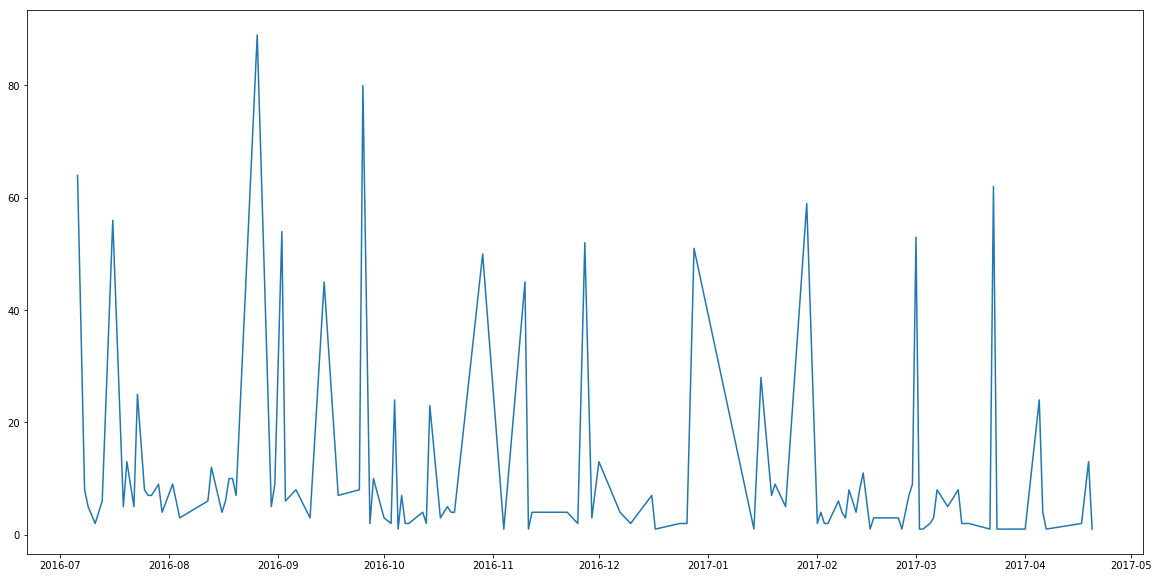

In [150]:
plt.figure(figsize=(20, 10))
plt.plot(trn.visit_date, trn.visitors)

In [182]:
store_info = data['as']
area_cnt = store_info.groupby('air_area_name')['air_store_id'].count().reset_index().rename({'air_store_id': 'store_in_area'}, axis=1)

# Submission

In [224]:
reload(utils)

<module 'utils' from '/Users/yangyang/workspace/ml_utils/proj/RRVF/utils.py'>

In [231]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = np.round(np.random.rand(len(trn_like_test)) * 100))
trn_like_test['visit_date'] = pd.to_datetime(trn_like_test.visit_date)
test_feas = utils.test2fea(trn_like_test, './data')
test_fest_mat = test_feas['sk_fea']


all_vars = test_feas['all_vars']
test_data = xgboost.DMatrix(test_fest_mat, feature_names=all_vars)


# test.to_csv('result/xgb_prop.csv', index=False)

In [232]:
preded_test = model.predict(test_data)
pred_test_orig = utils.log_max_inv(preded_test, max_log_y)
test.visitors = pred_test_orig

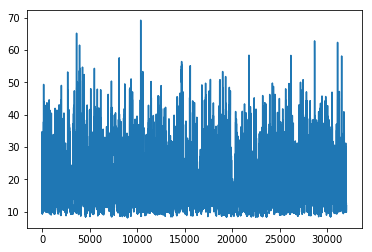

In [233]:
test.visitors.plot()

In [234]:
test.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,9.663620
1,air_00a91d42b08b08d9_2017-04-24,21.386616
2,air_00a91d42b08b08d9_2017-04-25,23.259064
3,air_00a91d42b08b08d9_2017-04-26,26.601915
4,air_00a91d42b08b08d9_2017-04-27,27.711676


In [235]:
test.to_csv('result/xgb_prop.csv', index=False)

In [244]:
tt = pd.read_csv('result/xgb_prop.csv')

In [245]:
tt.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,9.663620
1,air_00a91d42b08b08d9_2017-04-24,21.386616
2,air_00a91d42b08b08d9_2017-04-25,23.259064
3,air_00a91d42b08b08d9_2017-04-26,26.601915
4,air_00a91d42b08b08d9_2017-04-27,27.711676


# Merge XGB and Prophet

In [410]:
xgb_result = pd.read_csv('./result/xgb_prop.csv')
pp_result = pd.read_csv('./result/pp_submission.csv')
xgb_beat_pp_stores = pd.read_csv('./data/xgb_beat_prop_stores.csv')

In [412]:
stores = xgb_beat_pp_stores.aire_store_id.values

In [413]:
xgb_data = tes2trn(xgb_result)
pp_data = tes2trn(pp_result)
len(xgb_data), len(pp_data)

(32019, 32019)

In [414]:
xgb_sub = xgb_data[~xgb_data.air_store_id.isin(stores)]
pp_sub = pp_data[pp_data.air_store_id.isin(stores)]
len(xgb_sub), len(pp_sub)

(28977, 3042)

In [415]:
xgb_data.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,9.663620
1,air_00a91d42b08b08d9,2017-04-24,21.386616
2,air_00a91d42b08b08d9,2017-04-25,23.259064
3,air_00a91d42b08b08d9,2017-04-26,26.601915
4,air_00a91d42b08b08d9,2017-04-27,27.711676


In [416]:
final = xgb_sub.append(pp_sub)
len(final), final.head()

(32019,            air_store_id  visit_date   visitors
 0  air_00a91d42b08b08d9  2017-04-23   9.663620
 1  air_00a91d42b08b08d9  2017-04-24  21.386616
 2  air_00a91d42b08b08d9  2017-04-25  23.259064
 3  air_00a91d42b08b08d9  2017-04-26  26.601915
 4  air_00a91d42b08b08d9  2017-04-27  27.711676)

In [417]:
final_submission = trn2test(final)
final_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,9.663620
1,air_00a91d42b08b08d9_2017-04-24,21.386616
2,air_00a91d42b08b08d9_2017-04-25,23.259064
3,air_00a91d42b08b08d9_2017-04-26,26.601915
4,air_00a91d42b08b08d9_2017-04-27,27.711676


In [418]:
final_submission.loc[final_submission.visitors < 0, 'visitors'] = 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [419]:
final_submission.to_csv('./result/merge_xgb_prop.csv', index=False)

In [376]:
final_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,9.663620
1,air_00a91d42b08b08d9_2017-04-24,21.386616
2,air_00a91d42b08b08d9_2017-04-25,23.259064
3,air_00a91d42b08b08d9_2017-04-26,26.601915
4,air_00a91d42b08b08d9_2017-04-27,27.711676


In [16]:
def trn2test(tes_in_trn):
    tes_in_trn['id'] = tes_in_trn[['air_store_id', 'visit_date']].apply(
        lambda x: '_'.join(x), axis=1)
    return tes_in_trn[['id', 'visitors']]

In [15]:
def tes2trn(tes):
    tes = tes.assign(
        air_store_id=tes["id"].map(lambda x: '_'.join(x.split('_')[:-1])))
    tes = tes.assign(visit_date=tes["id"].map(lambda x: x.split('_')[2]))
    return tes[["air_store_id", "visit_date", 'visitors']]

In [381]:
pp_cv = pd.read_csv('./data/pp_cv_loss_base_model.csv')
tt = pd.read_csv('./data/sample_submission.csv')

In [387]:
pp_cv.head()

,aire_store_id,cv_loss0,train_loss,valid_loss
0,air_1c0b150f9e696a5f,-1.0,0.085170,0.081253
1,air_cf5ab75a0afb8af9,-1.0,0.319940,0.116670
2,air_a17f0778617c76e2,-1.0,0.473646,0.340431
3,air_a9a380530c1e121f,-1.0,0.190605,0.063417
4,air_789103bf53b8096b,-1.0,0.286448,0.175119


In [383]:
ttt = tes2trn(tt)

In [385]:
tt_stores = ttt.air_store_id.unique()

In [388]:
pp_cv_2 = pp_cv[pp_cv.aire_store_id.isin(tt_stores)]
len(pp_cv_2)

821

In [390]:
pp_cv_2.to_csv('./data/pp_cv_loss_base_model_for_test.csv', index=False)

# Remove outliers of Prophet Result

In [87]:
pp_result = pd.read_csv('./result/pp_submission.csv')
pp_removed = pp_result.copy()
pp_removed.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.713417
1,air_00a91d42b08b08d9_2017-04-24,22.902539
2,air_00a91d42b08b08d9_2017-04-25,24.945218
3,air_00a91d42b08b08d9_2017-04-26,30.442141
4,air_00a91d42b08b08d9_2017-04-27,32.736847


In [88]:
xgb_result = pd.read_csv('./result/xgb_prop.csv')

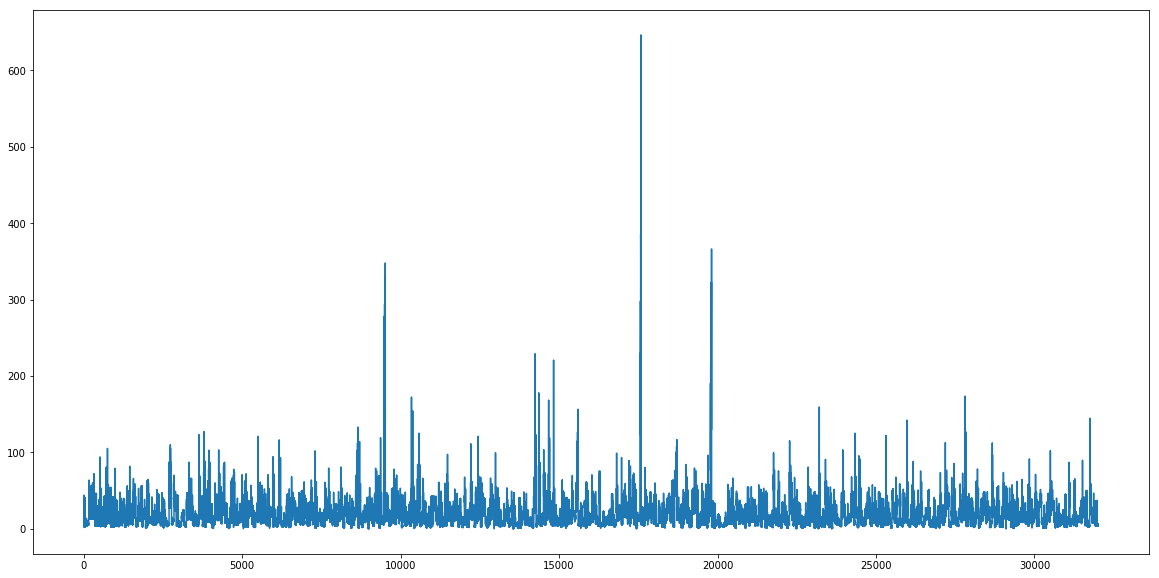

In [89]:
plt.plot(pp_removed.visitors)

In [90]:
pp_removed.loc[pp_removed.visitors <0, 'visitors'] = 0

In [91]:
outlier_id = pp_removed[pp_removed.visitors > 120].id

In [92]:
len(pp_removed), len(outlier_id)

(32019, 102)

In [80]:
for oid in outlier_id:
    pp_removed.loc[pp_removed.id == oid, 'visitors'] = xgb_result[xgb_result.id == oid].visitors

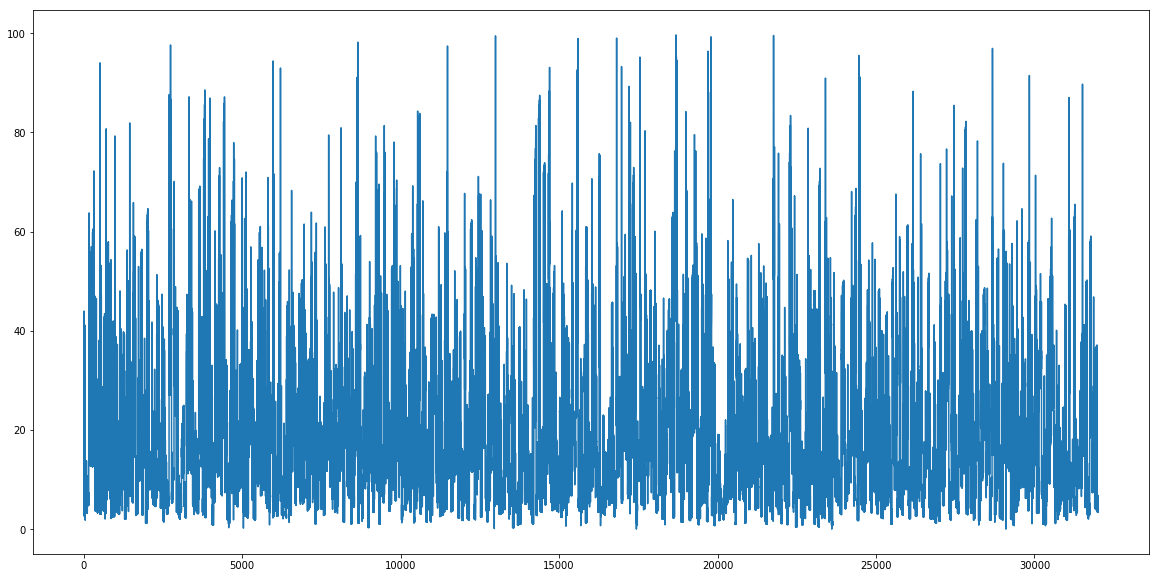

In [81]:
plt.plot(pp_removed.visitors)

In [82]:
pp_removed.to_csv('./result/pp_removed_100.csv', index=False)

In [9]:
len(pp_removed)

32019

In [17]:
pp_rfmt = tes2trn(pp_result)
pp_rfmt.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,2.713417
1,air_00a91d42b08b08d9,2017-04-24,22.902539
2,air_00a91d42b08b08d9,2017-04-25,24.945218
3,air_00a91d42b08b08d9,2017-04-26,30.442141
4,air_00a91d42b08b08d9,2017-04-27,32.736847


In [20]:
outliers = pp_rfmt[pp_rfmt.visitors > 120].air_store_id.unique()

In [21]:
outliers

array(['air_23e1b11aee2a1407', 'air_2545dd3a00f265e2',
       'air_31c753b48a657b6c', 'air_4b55d8aea1d2b395',
       'air_52a08ef3efdb4bb0', 'air_5afb1cca48ceaa19',
       'air_5b6d18c470bbfaf9', 'air_5c817ef28f236bdf',
       'air_67f87c159d9e2ee2', 'air_746211c0b532e8aa',
       'air_7514d90009613cd6', 'air_789103bf53b8096b',
       'air_79f528087f49df06', 'air_8110d68cc869b85e',
       'air_900d755ebd2f7bbd', 'air_9c6787aa03a45586',
       'air_b8a5ee69e5fdcc5b', 'air_c225148c0fcc5c72',
       'air_c8c0ef02ed72053f', 'air_ccd19a5bc5573ae5',
       'air_df554c4527a1cfe6', 'air_fe22ef5a9cbef123'], dtype=object)